In [1]:
import numpy as np
import matplotlib.pyplot as plt


from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit 


In [2]:
# Gaussian functions for the fitting of the doppler-broadened lines

def Gauss(x, A, D,x0): 
    y = A*np.exp(-(x-x0)**2/(2*D**2)) 
    return y 

def Gauss_2(x, A, D,x0, A2, D2, x02): 
    y = A*np.exp(-(x-x0)**2/(2*D**2)) + A2*np.exp(-(x-x02)**2/(2*D2**2)) 
    return y

In [3]:
# Frequency differences in MHZ between the 87 and 85 transitions, for the GS
f_87D2 = 384230484
f_85D2 = 384230406
f_87F1_rel = +4272
f_87F2_rel = -2563
f_85F2_rel = +1771
f_85F3_rel = -1265
df_87_F1 = f_87D2 + f_87F1_rel
df_87_F2 = f_87D2 + f_87F2_rel
df_85_F2 = f_85D2 + f_85F2_rel
df_85_F3 = f_85D2 + f_85F3_rel

# laser frequency, putting the zero to the resonance with 87_F1
fL_87_F1 = df_87_F1 - df_87_F1
fL_87_F2 = df_87_F2 - df_87_F1
fL_85_F2 = df_85_F2 - df_87_F1
fL_85_F3 = df_85_F3 - df_87_F1

fl_array = np.array([fL_87_F1,fL_85_F2,fL_85_F3,fL_87_F2])
print(fl_array)

[    0 -2579 -5615 -6835]


In [4]:
# this function finds where the voltage ramp of the function generator starts and ends

def find_extremes_ramp(x):
    t = np.arange(0,len(x))
    step = 5
    width = 25
    l_d = int((len(x)-width)/step)+1
    pos_arr = np.zeros(l_d)
    avg_arr = np.zeros(l_d)
    for i in range(l_d):
        pos_arr[i] = i*step + width/2
        avg_arr[i] = np.mean(x[i*step:i*step+width])
    start = pos_arr[np.argmin(avg_arr)]
    end = pos_arr[np.argmax(avg_arr)]
    if start > end:
        start,end = end,start
    return int(start),int(end)

# this function identifies the regions where the spectroscopy signal is linear (ie far from the resonances)

def find_where_linear(x):
    t = np.arange(0,len(x))
    step = 10
    width = 40
    l_dd = int((len(x)-width)/step)+1
    dd_arr = np.zeros(l_dd)
    pos_arr = np.zeros(l_dd)
    for i in range(l_dd):
        pfit = np.polyfit(t[i*step:i*step+width],x[i*step:i*step+width],2)
        dd_arr[i] = pfit[0]
        pos_arr[i] = i*step + width/2
    lim = np.amax(abs(dd_arr))/15
    plt.plot(pos_arr,abs(dd_arr))
    plt.axhline(y=lim, color='r', linestyle='-')
    dd_arr = abs(dd_arr)
    dd_arr[dd_arr<lim] = 0
    starts = np.zeros(4)
    ends = np.zeros(4)
    idx = 0
    running = False
    for i in range(len(dd_arr)-1):
        if (dd_arr[i] == 0) and (running == False):
            starts[idx] = pos_arr[i]
            running = True
            cnt = 1
        if (dd_arr[i] == 0) and (running == True):
            cnt += 1
        if (dd_arr[i] != 0) and (running == True):
            if cnt > 5:
                ends[idx] = pos_arr[i]
                idx += 1
                running = False
            if cnt<5:
                running = False
    ends[-1] = pos_arr[-1]
    return starts,ends



In [19]:
def Lor(x,x0,D,A):
    return A/(1+(x-x0)**2/D**2)

def SAS_fit(x,x1,D1,A1,x2,D2,A2,x3,D3,A3,x4,D4,A4,x5,D5,A5,x6,D6,A6,x0G,DG,AG):
    v = 0
    v += Lor(x,x1,D1,A1)
    v += Lor(x,x2,D2,A2)
    v += Lor(x,x3,D3,A3)
    v += Lor(x,x4,D4,A4)
    v += Lor(x,x5,D5,A5)
    v += Lor(x,x6,D6,A6)
    v += Gauss(x,AG,DG,x0G)
    return v

62 1147


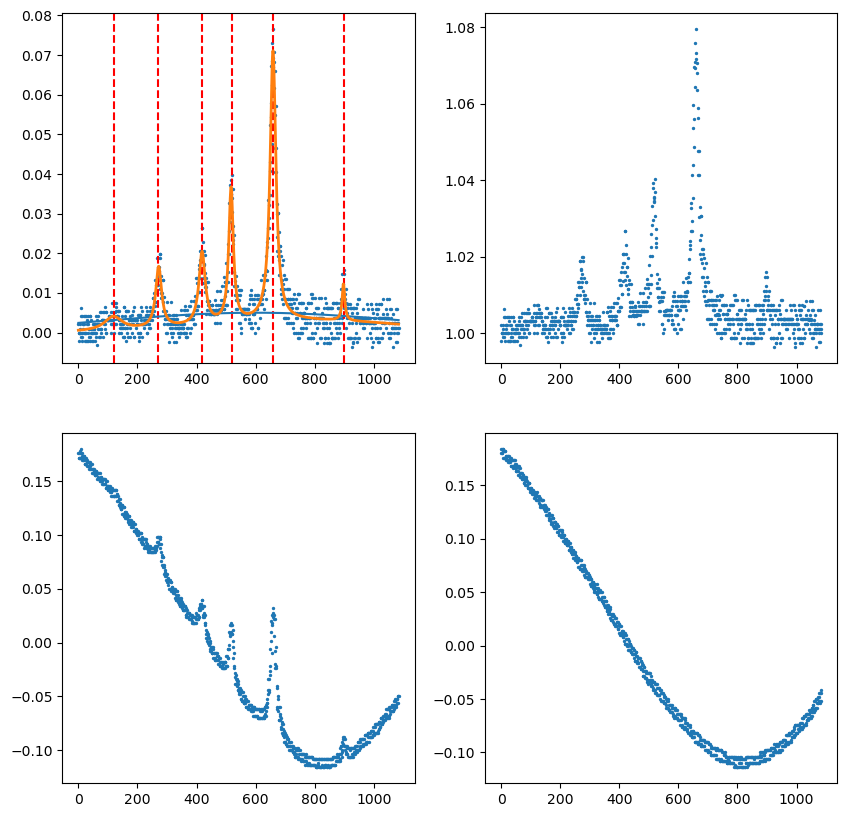

In [35]:
# plot files 18,19,29,21 froom JL_USB
V_1 = np.loadtxt("/media/jacklook/JL_USB/NewFile18.csv",skiprows=2,delimiter=",",dtype=str)
V_2 = np.loadtxt("/media/jacklook/JL_USB/NewFile19.csv",skiprows=2,delimiter=",",dtype=str)
V_3 = np.loadtxt("/media/jacklook/JL_USB/NewFile20.csv",skiprows=2,delimiter=",",dtype=str)
V_4 = np.loadtxt("/media/jacklook/JL_USB/NewFile21.csv",skiprows=2,delimiter=",",dtype=str)

V_0 = V_1[:,2].astype(float)
st,end = find_extremes_ramp(V_0)

print(st,end)
V_1 = V_1[st:end,1].astype(float)
V_2 = V_2[st:end,1].astype(float)
V_3 = V_3[st:end,1].astype(float)
V_4 = V_4[st:end,1].astype(float)

V_DB = V_1 -np.mean(V_1)+np.mean(V_2)
V_DF = V_4 -np.mean(V_4)+np.mean(V_3)

sg = np.log(V_DB/V_DF)

# plot in 4 different graphs
fig, axs = plt.subplots(2,2)
fig.set_size_inches(10, 10)
axs[1,0].scatter(np.arange(0,len(V_1)),V_1,s=2)
axs[1,1].scatter(np.arange(0,len(V_2)),V_4,s=2)
axs[0,0].scatter(np.arange(0,len(sg)),sg,s=2)
axs[0,1].scatter(np.arange(0,len(sg)),V_DB/V_DF,s=2)

in_centers = np.array([120,270,420,520,660,900])
# plot vertical lines
for i in range(len(in_centers)):
    axs[0,0].axvline(x=in_centers[i],color='r',linestyle='--')

# plot the SAS_fit function
x = np.arange(0,len(sg))
p0 = [120,10,0.008,270,10,0.015,420,10,0.018,520,10,0.035,660,10,0.09,900,10,0.01,600,500,0.005]

#axs[0,0].plot(x,SAS_fit(x,*p0))
axs[0,0].plot(x,Gauss(x,0.005,500,600))
popt, pcov = curve_fit(SAS_fit, x, sg, p0)
axs[0,0].plot(x,SAS_fit(x,*popt),lw=2)
plt.show()


[   34.14796331 -2625.46093108 -5644.23246438 -6793.45456785]
[284.81663086 277.06596559 285.97350971 313.1734811 ]
-0.024219524841069685 -82.57097671180641


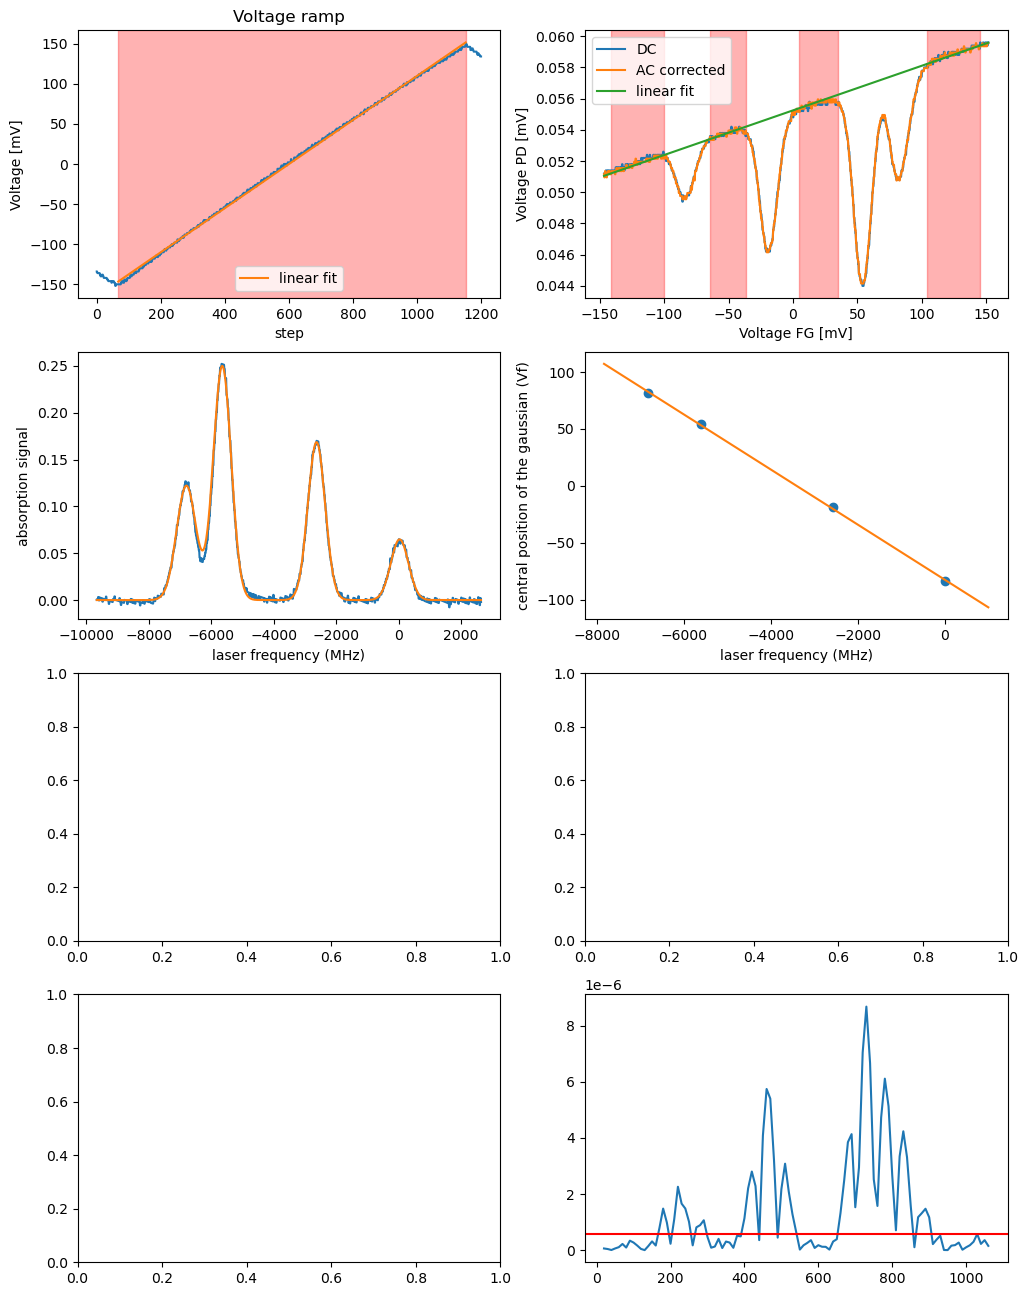

In [ ]:

# save same signal both as DC and AC, the first column is the function generator, the second the photodiode
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile13.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile12.csv", skiprows=2,delimiter=",",dtype=str)


# find extremes of the voltage ramp and cuts the data there
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]

# find the relation between step and ramp voltage by linear fit
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

# correct AC signal for DC offset
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find where the signal is linear and correct it
starts,ends = find_where_linear(Vpd)
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)
Vf_lin = Vf[lin_indexes]
Vpd_lin = Vpd[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]
Vpd_lin = Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b


ax[0,1].plot(Vf,V_DC,label='DC')
ax[0,1].plot(Vf,Vpd,label='AC corrected')
ax[0,1].set_xlabel('Voltage FG [mV]')
ax[0,1].set_ylabel('Voltage PD [mV]')
for i in range(4):
    ax[0,1].axvspan(Vf[int(starts[i])],Vf[int(ends[i])],color='r',alpha=0.3)
ax[0,1].plot(Vf,Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
ax[0,1].legend()

# get the absorption signal
Spd = -np.log(Vpd/Vpd_lin)

# find the gaussians
gauss_centers = np.array([(ends[0]+starts[1])/2, (ends[1]+starts[2])/2, ends[2]+(starts[3]-ends[2])/4, ends[2]+(starts[3]-ends[2])/4*3])
for i in range(4):
    gauss_centers[i] = Vf[int(gauss_centers[i])]
gauss_starts = np.array([ends[0],ends[1],ends[2],ends[2]+(starts[3]-ends[2])/2])
gauss_ends = np.array([starts[1],starts[2],starts[3]-(starts[3]-ends[2])/2,starts[3]])
gauss_widths = np.zeros(4)
gauss_A = np.zeros(4)
for i in range(4):
    start = int(gauss_starts[i])
    end = int(gauss_ends[i])
    t = np.arange(start,end)
    popt, pcov = curve_fit(Gauss, Vf[t], Spd[t], p0=[1, 1, gauss_centers[i]])
    gauss_centers[i] = popt[2]
    gauss_widths[i] = popt[1]
    gauss_A[i] = popt[0]

# fit Vf vs f
Vf_vs_f_linfit = np.polyfit(fl_array, gauss_centers, 1)
Vf_vs_f__a = Vf_vs_f_linfit[0]
Vf_vs_f__b = Vf_vs_f_linfit[1]
fs = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[1,1].plot(fl_array, gauss_centers, 'o', label='data')
fl_s = np.arange(fl_array[-1]-1000,fl_array[0]+1000)
ax[1,1].plot(fl_s, np.polyval(Vf_vs_f_linfit, fl_s), label='linear fit')
ax[1,1].set_xlabel('laser frequency (MHz)')
ax[1,1].set_ylabel('central position of the gaussian (Vf)')

gauss_centers = (gauss_centers-Vf_vs_f__b)/Vf_vs_f__a
gauss_widths = abs(gauss_widths/Vf_vs_f__a)

# sum all gaussians
Spd_fit = np.zeros(len(Vf))
Spd_fit += Gauss(fs,gauss_A[0],gauss_widths[0],gauss_centers[0])
Spd_fit += Gauss(fs,gauss_A[1],gauss_widths[1],gauss_centers[1])
Spd_fit += Gauss(fs,gauss_A[2],gauss_widths[2],gauss_centers[2])
Spd_fit += Gauss(fs,gauss_A[3],gauss_widths[3],gauss_centers[3])

ax[1,0].plot(fs,Spd)
ax[1,0].plot(fs,Spd_fit)
ax[1,0].set_xlabel('laser frequency (MHz)')
ax[1,0].set_ylabel('absorption signal')

# get the voltage for the laser frequency
def get_V(FL):
    return FL*Vf_vs_f__a+Vf_vs_f__b

print(gauss_centers)
print(gauss_widths)
Vf_a_1 = Vf_vs_f__a
Vf_b_1 = Vf_vs_f__b
print(Vf_vs_f__a,Vf_vs_f__b)




[   33.57445023 -2626.67889633 -5636.77047913 -6799.12507477]
[258.97800325 239.48680717 240.84309937 254.90809932]
-2.1712379212464583


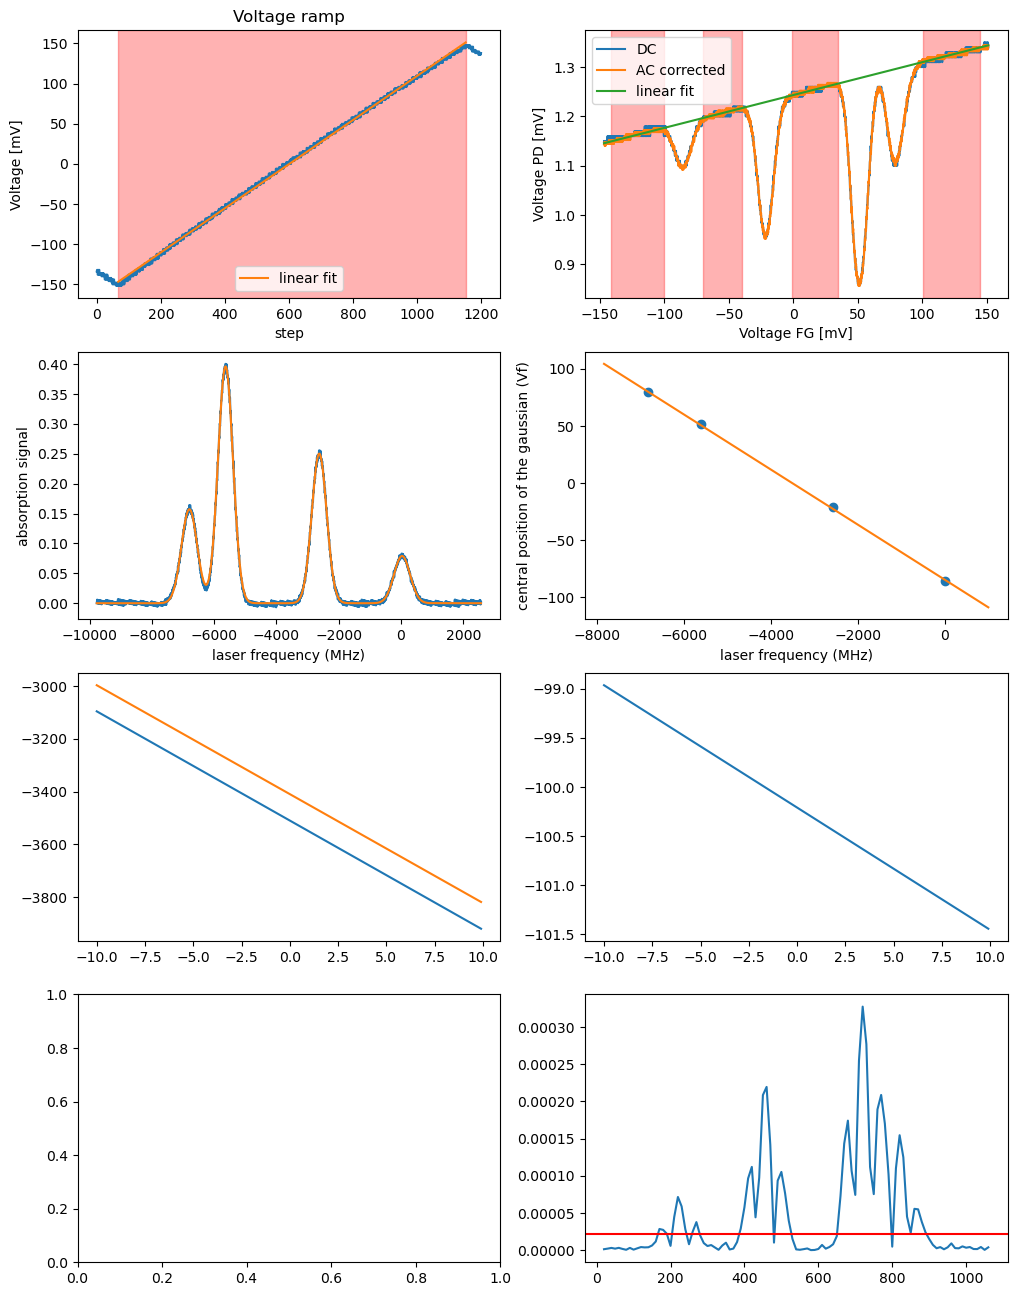

In [ ]:
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile9.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile8.csv", skiprows=2,delimiter=",",dtype=str)


# find extremes of the voltage ramp
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]

# find the relation between step and ramp voltage
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

# correct AC signal for DC offset
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find where the signal is linear and correct it
starts,ends = find_where_linear(Vpd)
lin_indexes = np.arange(int(starts[0]),int(ends[0]))
for i in range(1,4):
    lin_indexes = np.concatenate((lin_indexes,np.arange(int(starts[i]),int(ends[i]))))
lin_indexes = lin_indexes.astype(int)
Vf_lin = Vf[lin_indexes]
Vpd_lin = Vpd[lin_indexes]
Vpd_vs_Vf_linfit = np.polyfit(Vf_lin,Vpd_lin,1)
Vpd_vs_Vf_a = Vpd_vs_Vf_linfit[0]
Vpd_vs_Vf_b = Vpd_vs_Vf_linfit[1]
Vpd_lin = Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b


ax[0,1].plot(Vf,V_DC,label='DC')
ax[0,1].plot(Vf,Vpd,label='AC corrected')
ax[0,1].set_xlabel('Voltage FG [mV]')
ax[0,1].set_ylabel('Voltage PD [mV]')
for i in range(4):
    ax[0,1].axvspan(Vf[int(starts[i])],Vf[int(ends[i])],color='r',alpha=0.3)
ax[0,1].plot(Vf,Vf*Vpd_vs_Vf_a+Vpd_vs_Vf_b,label='linear fit')
ax[0,1].legend()

# get the absorption signal
Spd = -np.log(Vpd/Vpd_lin)

# find the gaussians
gauss_centers = np.array([(ends[0]+starts[1])/2, (ends[1]+starts[2])/2, ends[2]+(starts[3]-ends[2])/4, ends[2]+(starts[3]-ends[2])/4*3])
for i in range(4):
    gauss_centers[i] = Vf[int(gauss_centers[i])]
gauss_starts = np.array([ends[0],ends[1],ends[2],ends[2]+(starts[3]-ends[2])/2])
gauss_ends = np.array([starts[1],starts[2],starts[3]-(starts[3]-ends[2])/2,starts[3]])
gauss_widths = np.zeros(4)
gauss_A = np.zeros(4)
for i in range(4):
    start = int(gauss_starts[i])
    end = int(gauss_ends[i])
    t = np.arange(start,end)
    popt, pcov = curve_fit(Gauss, Vf[t], Spd[t], p0=[1, 1, gauss_centers[i]])
    gauss_centers[i] = popt[2]
    gauss_widths[i] = popt[1]
    gauss_A[i] = popt[0]

# fit Vf vs f
Vf_vs_f_linfit = np.polyfit(fl_array, gauss_centers, 1)
Vf_vs_f__a = Vf_vs_f_linfit[0]
Vf_vs_f__b = Vf_vs_f_linfit[1]
fs = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[1,1].plot(fl_array, gauss_centers, 'o', label='data')
fl_s = np.arange(fl_array[-1]-1000,fl_array[0]+1000)
ax[1,1].plot(fl_s, np.polyval(Vf_vs_f_linfit, fl_s), label='linear fit')
ax[1,1].set_xlabel('laser frequency (MHz)')
ax[1,1].set_ylabel('central position of the gaussian (Vf)')

gauss_centers = (gauss_centers-Vf_vs_f__b)/Vf_vs_f__a
gauss_widths = abs(gauss_widths/Vf_vs_f__a)

# sum all gaussians
Spd_fit = np.zeros(len(Vf))
Spd_fit += Gauss(fs,gauss_A[0],gauss_widths[0],gauss_centers[0])
Spd_fit += Gauss(fs,gauss_A[1],gauss_widths[1],gauss_centers[1])
Spd_fit += Gauss(fs,gauss_A[2],gauss_widths[2],gauss_centers[2])
Spd_fit += Gauss(fs,gauss_A[3],gauss_widths[3],gauss_centers[3])

ax[1,0].plot(fs,Spd)
ax[1,0].plot(fs,Spd_fit)
ax[1,0].set_xlabel('laser frequency (MHz)')
ax[1,0].set_ylabel('absorption signal')

# get the voltage for the laser frequency
def get_V(FL):
    return FL*Vf_vs_f__a+Vf_vs_f__b

print(gauss_centers)
print(gauss_widths)
Vf = np.arange(-10,10,0.1)
ax[2,0].plot(Vf,(Vf-Vf_vs_f__b)/Vf_vs_f__a)
ax[2,0].plot(Vf,(Vf-Vf_b_1)/Vf_a_1)
ax[2,1].plot(Vf,(Vf-Vf_vs_f__b)/Vf_vs_f__a-(Vf-Vf_b_1)/Vf_a_1)
print(Vf_vs_f__b-Vf_b_1)



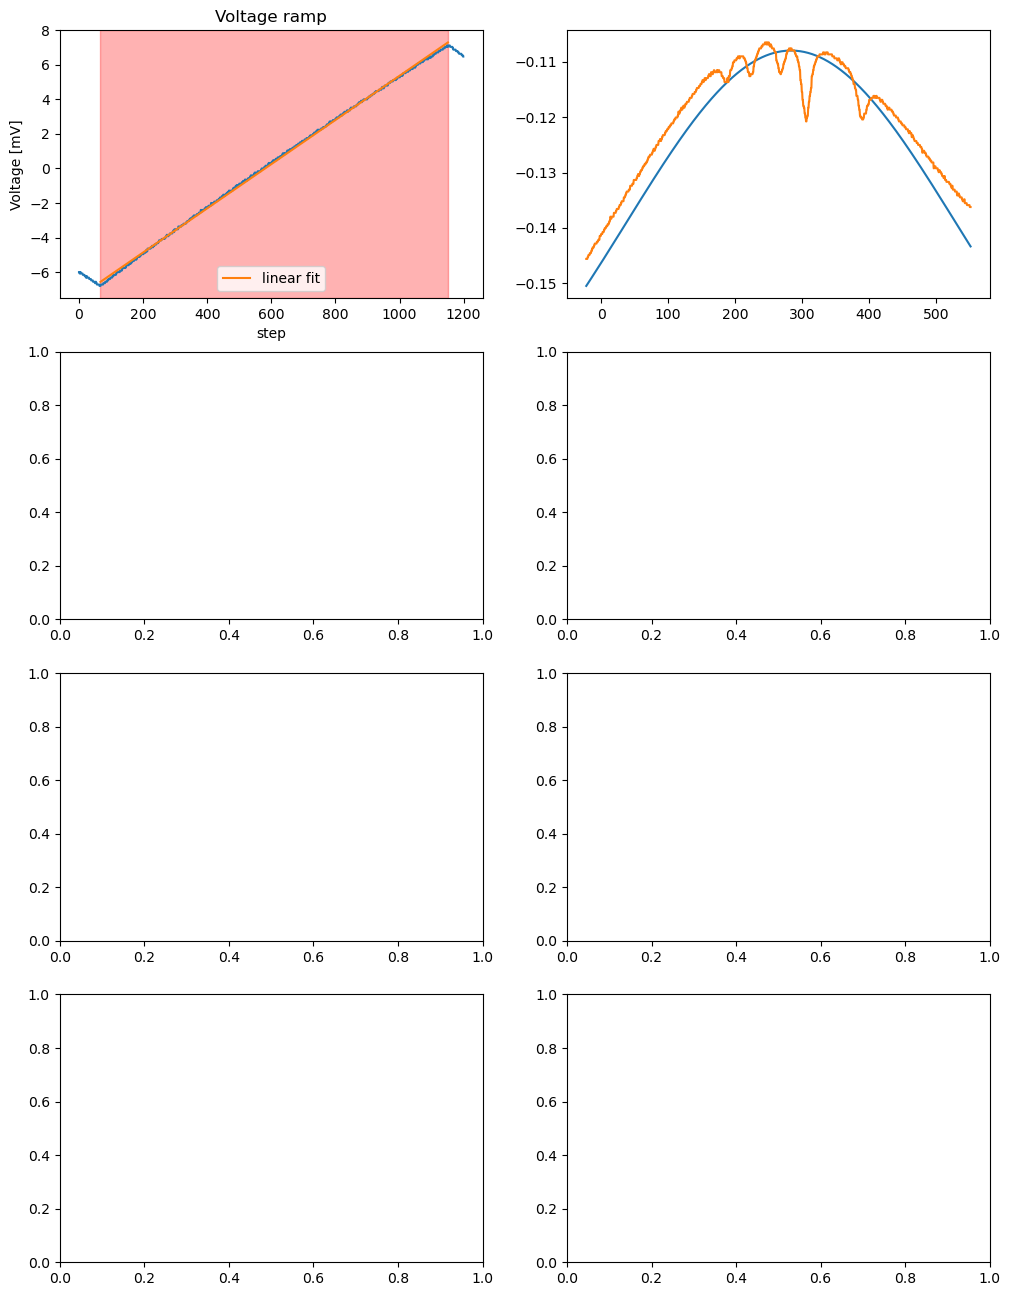

In [ ]:
DC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile10.csv", skiprows=2,delimiter=",",dtype=str)
AC_signal = np.loadtxt("/media/jacklook/JL_USB/NewFile11.csv", skiprows=2,delimiter=",",dtype=str)

# find extremes of the voltage ramp
V_fgen_DC = DC_signal[:,1].astype(float)*1000 # in mV
start,end = find_extremes_ramp(V_fgen_DC)
t_all = np.arange(0,len(V_fgen_DC))
t = t_all[start:end]

# extract the data between the extremes
V_DC = (DC_signal[:,2].astype(float))[start:end]
V_AC = (AC_signal[:,2].astype(float))[start:end]
Vpd = V_AC + np.mean(V_DC)-np.mean(V_AC)

# find the relation between step and ramp voltage
Vf_vs_t__linfit = np.polyfit(t,V_fgen_DC[start:end],1)
Vf_vs_t__a = Vf_vs_t__linfit[0]
Vf_vs_t__b = Vf_vs_t__linfit[1]
Vf = Vf_vs_t__a*t + Vf_vs_t__b-91.5

fig,ax = plt.subplots(4,2,figsize=(12,16))
ax[0,0].plot(t_all,V_fgen_DC)
ax[0,0].set_title('Voltage ramp')
ax[0,0].set_xlabel('step')
ax[0,0].set_ylabel('Voltage [mV]')
ax[0,0].plot(t,t*Vf_vs_t__a+Vf_vs_t__b,label='linear fit')
ax[0,0].axvspan(start,end,color='r',alpha=0.3)
ax[0,0].legend()

HF_f = (Vf-Vf_vs_f__b)/Vf_vs_f__a

ax[0,1].plot(HF_f,Gauss(HF_f,gauss_A[0]*1.,gauss_widths[0]*0.95,gauss_centers[0]+250)-0.187,label='DC')
ax[0,1].plot(HF_f,-np.log(Vpd),label='DC')



NameError: name 'HF_Vpd' is not defined

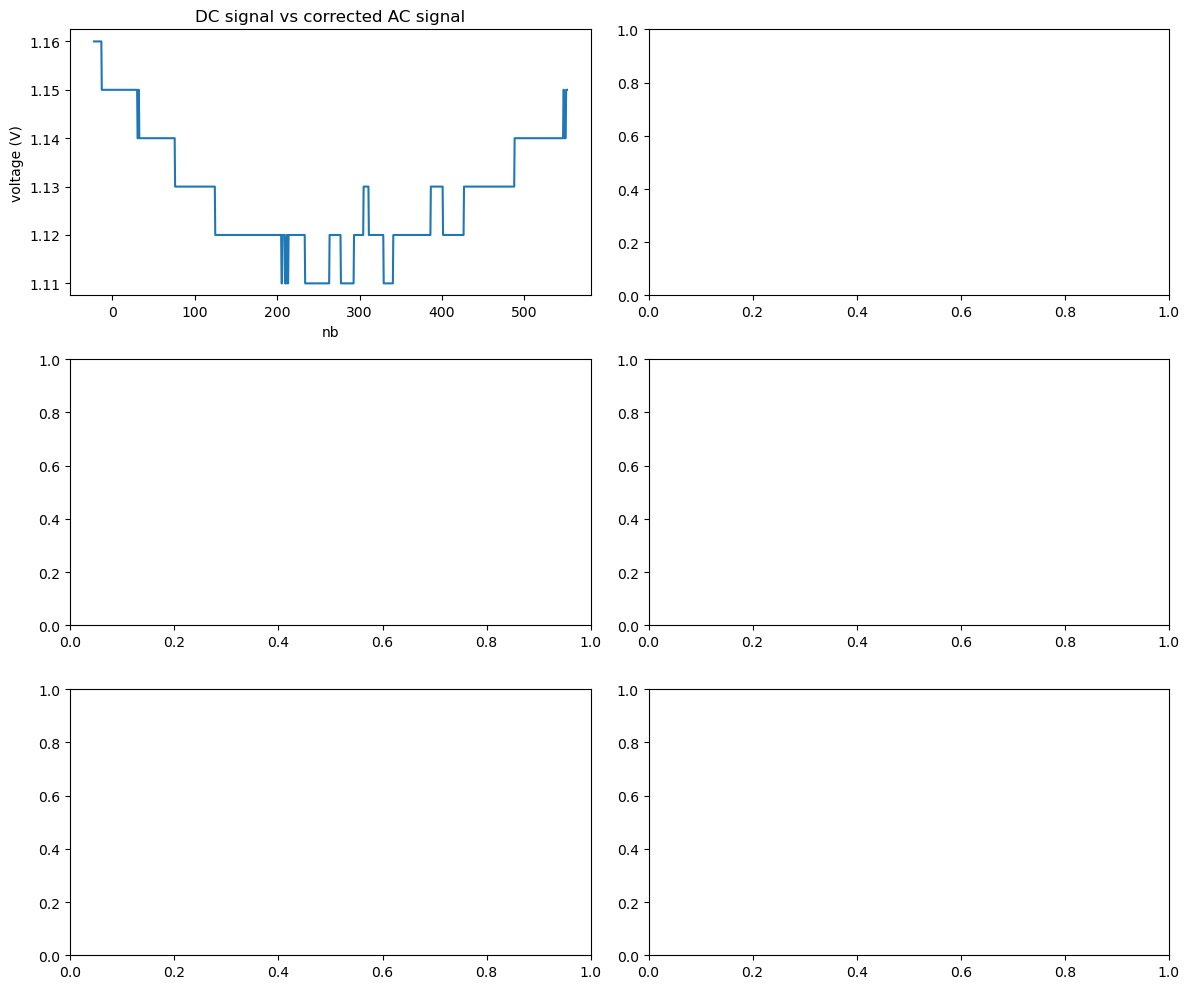

In [ ]:
# plot the data
fig, ax = plt.subplots(3, 2, figsize=(12, 10),tight_layout=True)
ax[0,0].plot(HF_f, V_DC, label='DC signal')
ax[0,0].set_title('DC signal vs corrected AC signal')
ax[0,0].set_xlabel('nb')
ax[0,0].set_ylabel('voltage (V)')
ax[0,0].plot(HF_f,HF_Vpd, label='AC signal corrected')
ax[0,0].legend()
ax[0,1].plot(t_AC, HF_Vf_vs_t__a*t_AC+HF_Vf_vs_t__b-91.5)

#HF_Vpd = HF_Vpd/(Vpd_vs_Vf__a*((t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)+Vpd_vs_Vf__b))

print(x0[0])
V_abs = np.zeros(len(HF_Vpd))
for i in range(len(HF_Vpd)):
    try:
        V_abs[i] = -np.log(HF_Vpd[i])
        print(HF_Vpd[i],V_abs[i])
    except:
        print(HF_Vpd[i])
ax[0,1].plot(HF_f, V_abs, label='AC signal corrected')
ax[1,1].plot((t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)*a_Vf+b_Vf,Vpd_vs_Vf__a*(t_AC*HF_Vf_vs_t__a+HF_Vf_vs_t__b-91.5)+Vpd_vs_Vf__b)
ax[1,0].plot(HF_f,-np.log(HF_Vpd))


[237.73606802 505.7734614  809.14347737 925.72642261]


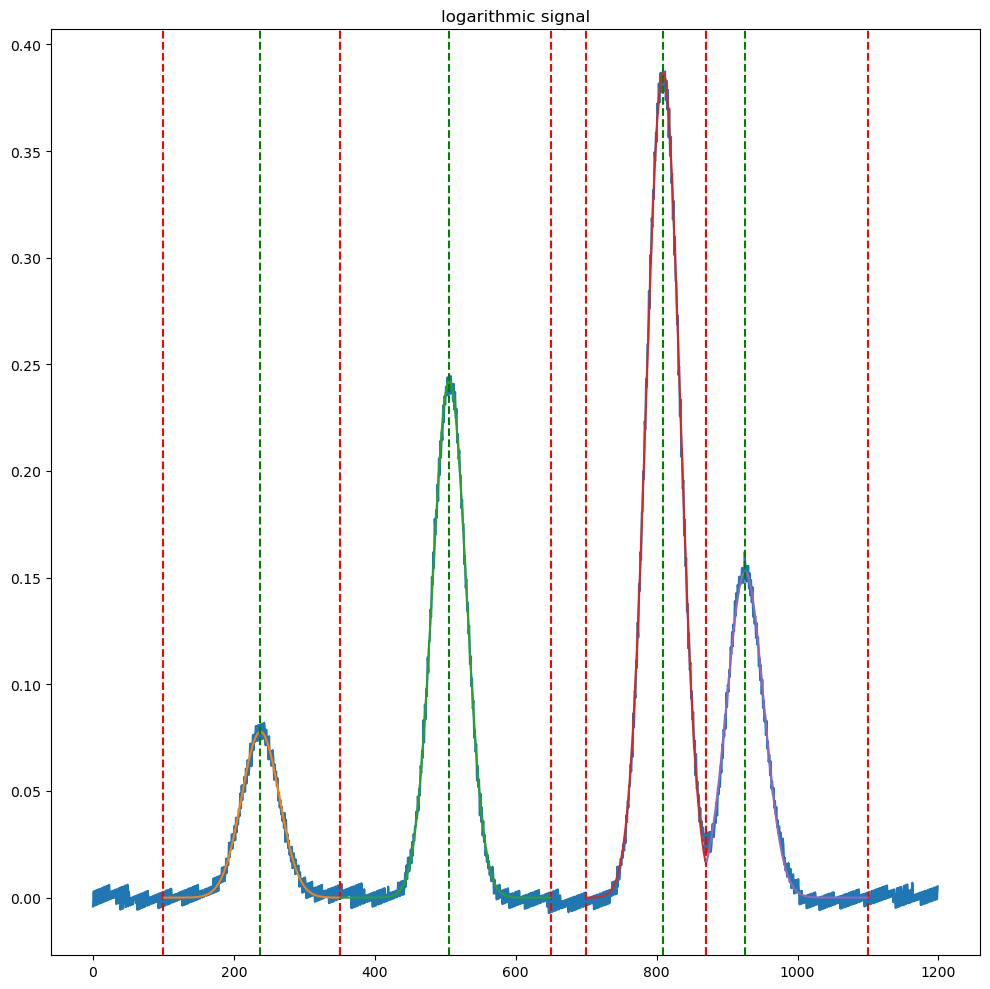

In [ ]:
# plot V,t divided by linear fit and take the negative of their log
V_lin = V/np.polyval(lin_fit, t)
t_lin = t
V_abs = -np.log(V_lin)
t_log = t_lin
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
axt.plot(t_log, V_abs)
axt.set_title('logarithmic signal') 
t_gauss_start = [100,350,700,870]
t_gauss_end = [350,650,870,1100]
# plot vertical lines in ax2 at t_starts and t_ends
for t_start, t_end in zip(t_gauss_start, t_gauss_end):
    axt.axvline(t_start, color='r', linestyle='--')
    axt.axvline(t_end, color='r', linestyle='--')

# select the data between t_start and t_end, do a gaussian fit and plot the fit and save the center positions in an array
x0 = np.array([])
for t_start, t_end in zip(t_gauss_start, t_gauss_end):
    V_gauss = V_abs[(t_log > t_start) & (t_log < t_end)]
    t_gauss = t_log[(t_log > t_start) & (t_log < t_end)]
    popt, pcov = curve_fit(Gauss, t_gauss, V_gauss, p0=[1, 1, (t_start+t_end)/2])
    x0 = np.append(x0, popt[2])
    axt.plot(t_gauss, Gauss(t_gauss, *popt), label='Gaussian fit')

# plot the center positions of the gaussians as vertical lines
for x in x0:
    axt.axvline(x, color='g', linestyle='--')

# print center positions
print(x0)

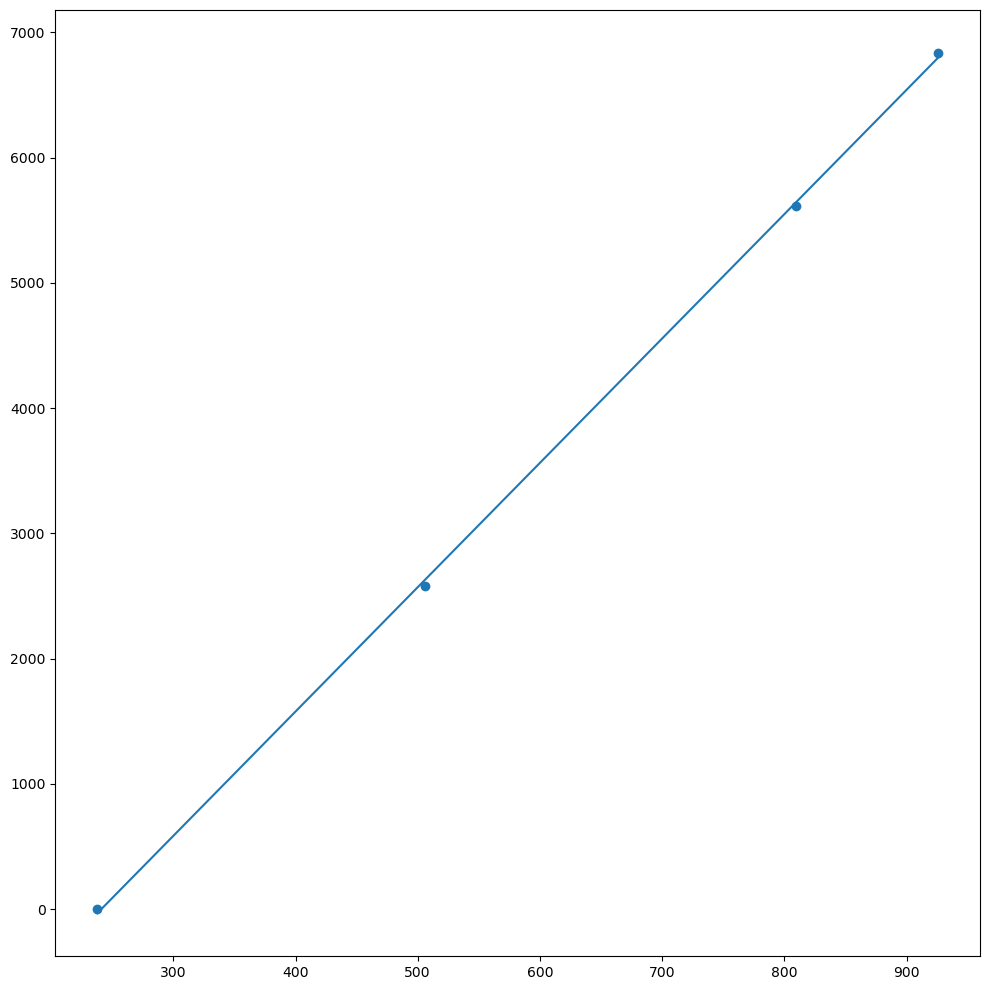

In [ ]:
D_real = np.array([0,2579,5615,6835])
# make a linear fit to the center positions and the real distances
lin_fit = np.polyfit(x0, D_real, 1)
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
# plot the linear fit
axt.plot(x0, np.polyval(lin_fit, x0), label='linear fit')
# plot the original data
axt.scatter(x0, D_real, label='real distances')


[ -33.5511579  2627.31848708 5638.94330738 6796.28936345]
6829.840521350624


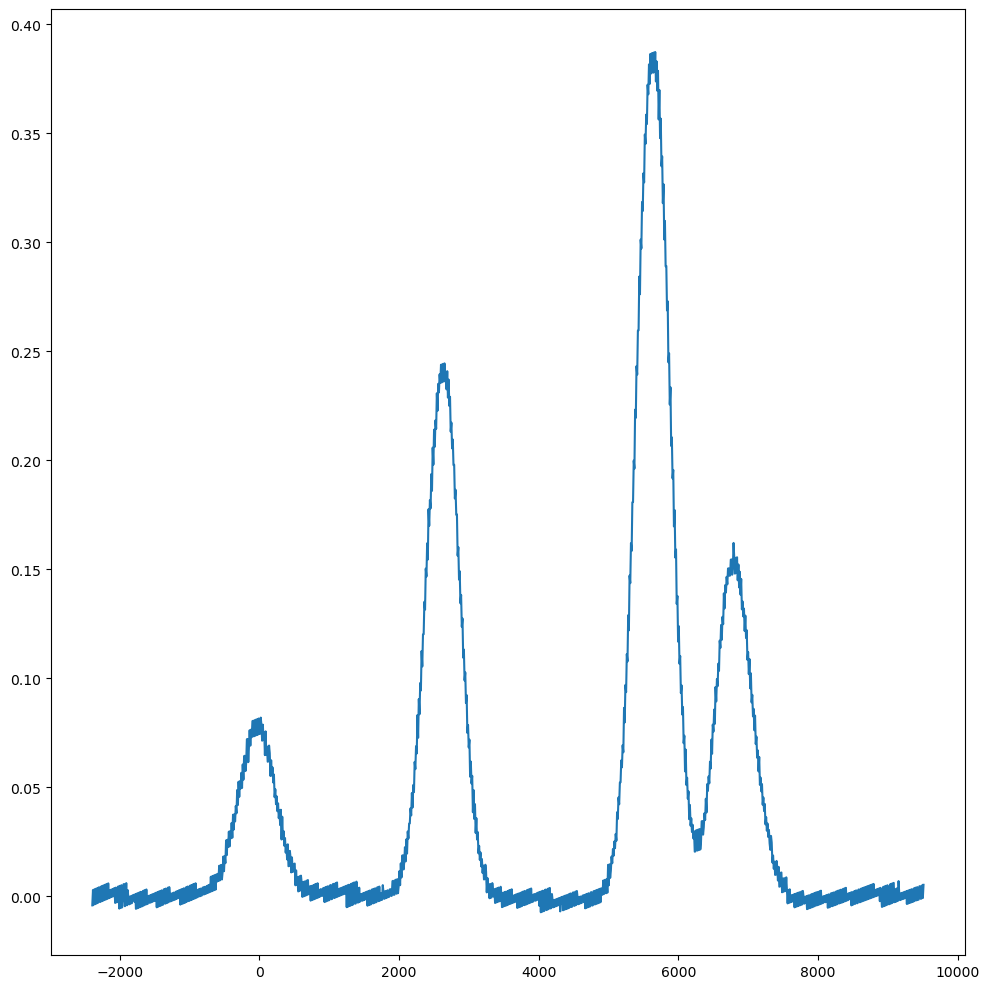

In [ ]:
# rescale t_log with the linear fit
f_x = np.polyval(lin_fit, t_log)
fig,axt = plt.subplots(1, 1, figsize=(10, 10),tight_layout=True)
axt.plot(f_x,V_abs)
f0 = np.polyval(lin_fit, x0)
print(f0)
print(f0[3]-f0[0])


mean of signal is -0.07889
std of signal is 0.0943035236174485
max of signal is 0.068
min of signal is -0.388
peak to peak of signal is 0.456
V_linear is [0.9063404  0.92634107 0.92634107 0.9063404  0.9063404  0.92634107
 0.9063404  0.92634107 0.9063404  0.92634107 0.9063404  0.92634107
 0.9063404  0.92634107 0.92634107 0.8964881  0.91629073 0.8964881
 0.91629073 0.8964881  0.91629073 0.8964881  0.8964881  0.91629073
 0.91629073 0.8964881  0.91629073 0.8964881  0.91629073 0.8964881
 0.8964881  0.91629073 0.8964881  0.91629073 0.91629073 0.8964881
 0.8964881  0.91629073 0.8964881  0.91629073 0.91629073 0.8964881
 0.91629073 0.8964881  0.8964881  0.91629073 0.9063404  0.8964881
 0.9063404  0.8964881  0.8964881  0.9063404  0.8964881  0.9063404
 0.9063404  0.8964881  0.8964881  0.9063404  0.9063404  0.88673193
 0.88673193 0.9063404  0.88673193 0.9063404  0.9063404  0.88673193
 0.88673193 0.9063404  0.9063404  0.88673193 0.88673193 0.9063404
 0.88673193 0.9063404  0.88673193 0.9063404  0.88

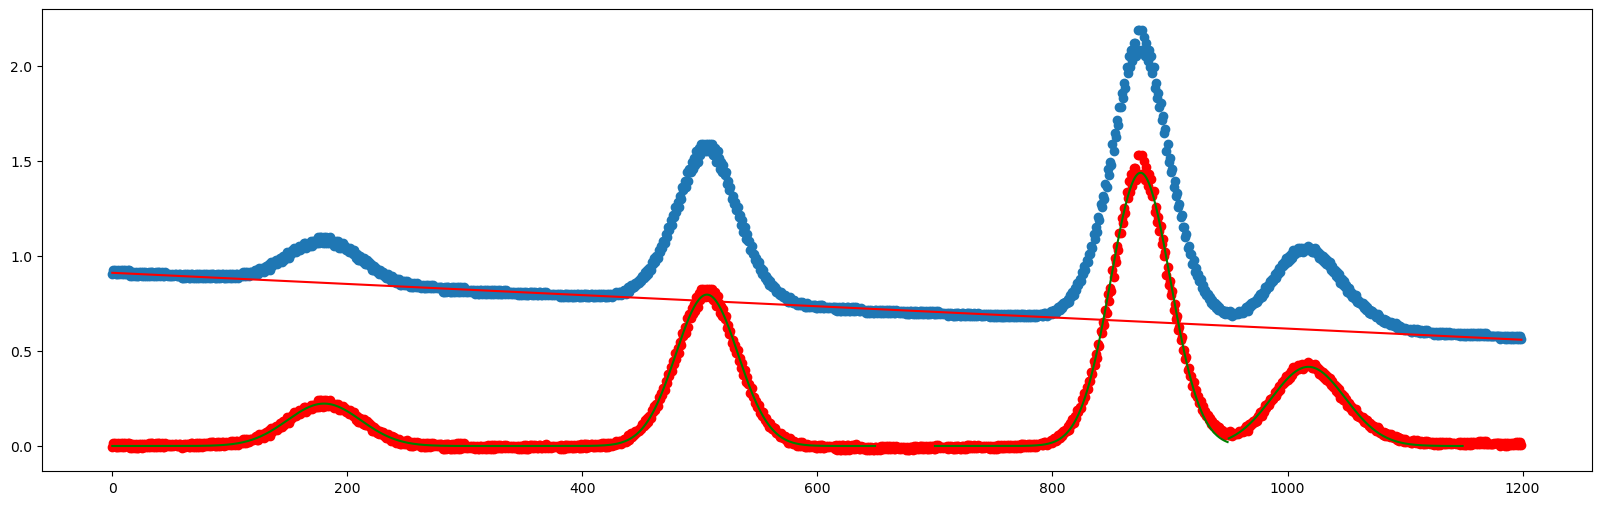

In [ ]:

IvsP = np.loadtxt("/media/jacklook/JJ_memory/NewFile12.csv", skiprows=2,delimiter=",",dtype=str)
#IvsP1 = np.loadtxt("/media/jacklook/JJ_memory/NewFile11.csv", skiprows=2,delimiter=",",dtype=str)
#IvSP2 = np.loadtxt("/media/jacklook/JJ_memory/NewFile3.csv", skiprows=2,delimiter=",",dtype=str)
#IvSP3 = np.loadtxt("/media/jacklook/JJ_memory/NewFile2.csv", skiprows=2,delimiter=",",dtype=str)
#V2 = np.asarray(IvSP2[:,1], dtype=float)
#V3 = np.asarray(IvSP3[:,1], dtype=float)
V0 = np.asarray(IvsP[:,1], dtype=float)
t0 = np.asarray(IvsP[:,0], dtype=float) 
#V1 = np.asarray(IvsP1[:,1], dtype=float)


figure, ax = plt.subplots()
figure.set_size_inches(20, 6)
V = np.asarray(IvsP[:,1], dtype=float)
#V2 = np.asarray(IvsP1[:,1], dtype=float)

print('mean of signal is', np.mean(V))
print('std of signal is', np.std(V))
print('max of signal is', np.max(V))
print('min of signal is', np.min(V))
print('peak to peak of signal is', np.max(V)-np.min(V))

#plt.scatter(np.arange(len(V)), V1-0.004)
#plt.scatter(np.arange(len(V)), V0)
plt.scatter(t0, -np.log(V0+0.5))
#plt.scatter(np.arange(len(V)), np.log(V0+0.004-V1))
#plt.ylim(-10,0)
#plt.scatter(np.arange(len(V)), np.log(V2-V3))
# isolate data from 0 to 100, from 250 to 350, from 600 to 750 and from 1150 to 1200
t_start =[0, 250, 600, 1150]
t_end = [100, 350, 750, 1200]
V_linear = np.array([])
t_linear = np.array([])
for i in range(4):
    V_linear = np.concatenate((V_linear, -np.log(V0[int(t_start[i]):int(t_end[i])]+0.5)))
    t_linear = np.concatenate((t_linear, t0[int(t_start[i]):int(t_end[i])]))
print('V_linear is', V_linear)
print('t_linear is', t_linear)
# now do linear fit on all V_linear
fit = np.polyfit(t_linear, V_linear, 1)
print('fit is', fit)
# now plot the linear fit
plt.plot(t_linear, fit[0]*t_linear+fit[1], 'r')

# now plot the original plot taking away the linear fit
plt.scatter(t0, -np.log(V0+0.5)-(fit[0]*t0+fit[1]), c='r')
# now fit a gaussian function in the first 350 data points
t_fit = t0[:350]
V_fit = -np.log(V0[:350]+0.5)-(fit[0]*t0[:350]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 100])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 350 to 650
t_fit = t0[350:650]
V_fit = -np.log(V0[350:650]+0.5)-(fit[0]*t0[350:650]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 500])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 700 to 950
t_fit = t0[700:950]
V_fit = -np.log(V0[700:950]+0.5)-(fit[0]*t0[700:950]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 800])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now fit gaussian from 950 to 1150
t_fit = t0[950:1150]
V_fit = -np.log(V0[950:1150]+0.5)-(fit[0]*t0[950:1150]+fit[1])
popt, pcov = curve_fit(Gauss, t_fit, V_fit, p0=[1, 1, 1050])
print('popt is', popt)
plt.plot(t_fit, Gauss(t_fit, *popt), 'g')

# now rescale x axis with first and last gaussian centers corresponding to 0 and 6.8
t_new = 




In [ ]:
#plt.scatter(np.arange(len(V1)), V1)
V_diff = V[1:]-V[:-1]
V_div = np.amin(V_diff[V_diff>0])
print(V_div)
print(0.001*10/256)
n = 50
new_V = np.zeros(len(V)-n)
for i in range(len(new_V)):
    new_V[i] = np.mean(V[i:i+n])
plt.plot(np.arange(len(new_V))/100, new_V)


Vdiv 0.00399999999999999 0.009999999999999787
[ 0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.   -0.01  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.   -0.01  0.    0.
  0.    0.    0.    0.  ]
Vpp 0.08 0.54
0.108 2.14
0.000421875 0.008359375


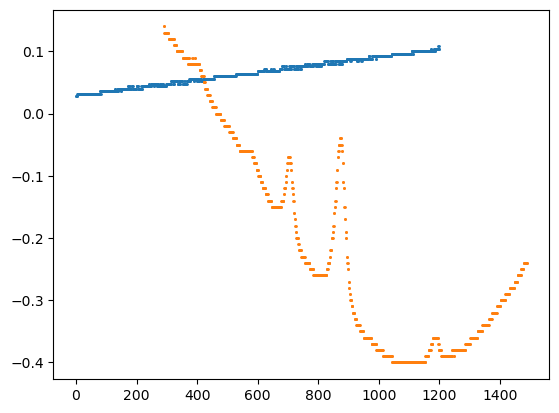

In [ ]:
IvsP = np.loadtxt("Data/Old/NewFile19.csv", skiprows=2,delimiter=",",dtype=str)
V = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V)), V,s=1)
IvsP = np.loadtxt("Data/NewFile18.csv", skiprows=2,delimiter=",",dtype=str)
V1 = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V1))+290, V1-2,s=1)
V_diff = V[1:]-V[:-1]
V_div = np.amin(V_diff[V_diff>0])
V1_diff = V1[1:]-V1[:-1]
V1_div = np.amin(V1_diff[V1_diff>0])
print("Vdiv",V_div, V1_div)
print(V1_diff[:40])
V_pp = np.amax(V)-np.amin(V)
V1_pp = np.amax(V1)-np.amin(V1)
print("Vpp",V_pp, V1_pp)
V_max = np.amax(V)
V1_max = np.amax(V1)
print(V_max, V1_max)
print(V_max/256, V1_max/256)



[1.77 1.77 1.77 1.77 1.77 1.77 1.78 1.78 1.78 1.78 1.78 1.78 1.78 1.78
 1.78 1.78 1.78 1.78 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79 1.79
 1.79 1.79 1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8  1.8
 1.8  1.8  1.81 1.81 1.81 1.81 1.81 1.81 1.82 1.82 1.82 1.82 1.82 1.82
 1.82 1.82 1.82 1.82 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.83 1.84 1.84
 1.84 1.84 1.84 1.84 1.84 1.84 1.85 1.85 1.85 1.85 1.85 1.85 1.86 1.86
 1.86 1.86 1.86 1.86 1.86 1.86 1.86 1.86 1.87 1.87 1.87 1.87 1.87 1.87
 1.87 1.87]


0.2048

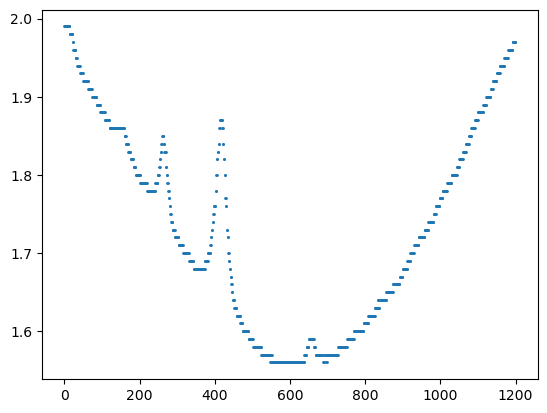

In [ ]:
IvsP = np.loadtxt("Data/NewFile2.csv", skiprows=2,delimiter=",",dtype=str)
V = np.asarray(IvsP[:,1], dtype=float)
plt.scatter(np.arange(len(V)), V,s=1)
print(V[1000:1100])
0.0008*256

In [ ]:
def find_extremes_ramp_2(x):
    t = np.arange(0,len(x))
    step = 5
    width = 25
    l_d = int((len(x)-width)/step)+1
    d_arr = np.zeros(l_d)
    pos_arr = np.zeros(l_d)
    avg_arr = np.zeros(l_d)
    for i in range(l_d):
        lfit = np.polyfit(t[i*step:i*step+width],x[i*step:i*step+width],1)
        d_arr[i] = lfit[0]
        pos_arr[i] = i*step + width/2
        avg_arr[i] = np.mean(x[i*step:i*step+width])
    # find the two values of d_arr that are closest to zero
    idx = np.argsort(abs(d_arr))
    cnt = 0
    start = 0
    end = 0
    bl_start_found = False
    bl_end_found = False
    found_all = False
    while (cnt<len(idx)) and (found_all == False):
        i = int(idx[cnt])
        if (i<len(idx)/2) and (bl_start_found == False):
            start = pos_arr[i]
            bl_start_found = True
        if (i>len(idx)/2) and (bl_end_found == False):
            end = pos_arr[i]
            bl_end_found = True
        if (bl_start_found == True) and (bl_end_found == True):
            found_all = True
        cnt+=1
    start1 = pos_arr[np.argmin(avg_arr)]
    end1 = pos_arr[np.argmax(avg_arr)]
    print(start,end)
    print(start1,end1)
    return start,end